In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaymann/car-number-plate-dataset-yolo-format")

print("Path to dataset files:", path)

Path to dataset files: /Users/nicolasreyalonso/.cache/kagglehub/datasets/sujaymann/car-number-plate-dataset-yolo-format/versions/3


## Detección de vehículos 
Aquí se procesa un vídeo propio para detectar vehículos y extraer la región inferior de cada coche,  
donde normalmente se encuentra la matrícula.  
Los resultados son los sogueientes: El video -> "salida_simple.mp4" y el csv -> "detecciones_simple.csv" 


## Entrenamiento IA — Descarga y entrenamiento del detector de matrículas
En esta sección se repite el proceso de descarga del dataset y entrenamiento del modelo YOLO para detectar matrículas,  
ajustando los parámetros de tamaño de imagen, lotes y épocas.  
Los resultados en la carpeta "detecciones".


### Descarga DS

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaymann/car-number-plate-dataset-yolo-format")

print("Path to dataset files:", path)

### Entrenar

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

model.train(
    data="data.yaml",
    imgsz=416,
    epochs=10,
    batch=4,
    device="mps",
    name="matriculas_detector2"
)


In [9]:
import os
from ultralytics import YOLO
import cv2

# Cargar el modelo entrenado
model = YOLO("runs/detect/matriculas_detector24/weights/best.pt")

# Carpeta de imágenes
input_folder = "./Matriculas"
output_folder = "detecciones"
os.makedirs(output_folder, exist_ok=True)

for img_name in os.listdir(input_folder):
    if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(input_folder, img_name)
    results = model(img_path, verbose=False)

    # Guardar detecciones con bounding boxes dibujadas
    results[0].save(filename=os.path.join(output_folder, f"det_{img_name}"))

    print(f"Procesada {img_name}")


Procesada GC9092BP_7466_aug2.jpg
Procesada SG4693.jpg
Procesada SE6207DV_1344_aug3.jpg
Procesada MR07AJO.jpg
Procesada SE6207DV_1344_aug2.jpg
Procesada GC9092BP_7466_aug3.jpg
Procesada GC1524.jpg
Procesada GC9092BP_7466_aug1.jpg
Procesada GC8521CG_7430_aug5.jpg
Procesada SE6207DV_1344_aug1.jpg
Procesada GC8521CG_7430_aug4.jpg
Procesada GC9092BP_7466_aug4.jpg
Procesada SE6207DV_1344_aug5.jpg
Procesada SE6207DV_1344_aug4.jpg
Procesada GC8521CG_7430_aug1.jpg
Procesada GC9092BP_7466_aug5.jpg
Procesada GC8521CG_7430_aug3.jpg
Procesada GC8521CG_7430_aug2.jpg
Procesada 7166NCG.jpg
Procesada H2965BBB_437_aug5.jpg
Procesada H2965BBB_437_aug4.jpg
Procesada H2965BBB_437_aug1.jpg
Procesada H2965BBB_437_aug3.jpg
Procesada 3765FGF.jpg
Procesada H2965BBB_437_aug2.jpg
Procesada 9140HMM.jpg
Procesada L33OWO.jpg


## Lectura de matrículas detectadas con EasyOCR
En este apartado se utilizan las imágenes generadas por el modelo YOLO entrenado (`detecciones/`) para aplicar reconocimiento óptico de caracteres (OCR) mediante **EasyOCR**.  

Para cada imagen:
- El modelo YOLO detecta la región de la matrícula.
- Se recorta esa zona y se convierte a escala de grises con ecualización de histograma para mejorar el contraste.
- EasyOCR intenta leer el texto presente en la matrícula y devuelve la predicción con su nivel de confianza.

Los resultados se imprimen en consola y se guardan en el archivo `lecturas_matriculas.csv`, indicando el nombre de la imagen, el texto leído y la confianza asociada.

In [8]:
import os
import cv2
import time
import csv
from ultralytics import YOLO
import easyocr

# Modelo YOLO entrenado
model = YOLO("runs/detect/matriculas_detector24/weights/best.pt")
reader = easyocr.Reader(['en'])

input_folder = "detecciones"
output_csv = "lecturas_matriculas.csv"

with open(output_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["imagen", "matricula", "confianza", "tiempo_inferencia_ms"])

    for img_name in os.listdir(input_folder):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(input_folder, img_name)
        image = cv2.imread(img_path)

        # ⏱ Inicio de medición
        start_time = time.time()

        # Detección de matrículas con YOLO
        results = model(image, verbose=False)
        detecciones = results[0].boxes

        if detecciones is None or len(detecciones) == 0:
            tiempo_ms = (time.time() - start_time) * 1000
            writer.writerow([img_name, "NO DETECTADA", "", f"{tiempo_ms:.1f}"])
            print(f"{img_name}: sin detección ({tiempo_ms:.1f} ms)")
            continue

        # OCR sobre cada detección
        for box in detecciones:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            placa = image[y1:y2, x1:x2]
            if placa.size == 0:
                continue

            # Procesamiento para OCR
            gris = cv2.cvtColor(placa, cv2.COLOR_BGR2GRAY)
            gris = cv2.equalizeHist(gris)

            ocr_res = reader.readtext(gris, detail=1, paragraph=False)

            # ⏱ Fin de medición total (detección + OCR)
            tiempo_ms = (time.time() - start_time) * 1000

            if len(ocr_res) > 0:
                mejor = max(ocr_res, key=lambda x: x[2])
                texto = mejor[1].upper().strip()
                conf = mejor[2]
                writer.writerow([img_name, texto, f"{conf:.2f}", f"{tiempo_ms:.1f}"])
                print(f"{img_name}: {texto} ({conf:.2f}) - {tiempo_ms:.1f} ms")
            else:
                writer.writerow([img_name, "NO LEÍDA", ""])


det_H2965BBB_437_aug5.jpg: sin detección (107.1 ms)


/opt/anaconda3/envs/VC_P4/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


det_H2965BBB_437_aug4.jpg: H2965 (1.00) - 2116.0 ms
det_H2965BBB_437_aug4.jpg: MATRICULA 0.36 (0.78) - 2384.1 ms
det_9140HMM.jpg: sin detección (39.7 ms)
det_H2965BBB_437_aug1.jpg: sin detección (22.7 ms)
det_H2965BBB_437_aug3.jpg: sin detección (19.4 ms)
det_H2965BBB_437_aug2.jpg: H2965 BBB (0.97) - 585.8 ms
det_GC1524.jpg: sin detección (35.3 ms)
det_SG4693.jpg: SG: L693 (0.48) - 88.7 ms
det_SG4693.jpg: MATRC (0.75) - 482.8 ms
det_GC9092BP_7466_aug1.jpg: GC 9092 BP (0.73) - 489.6 ms
det_GC8521CG_7430_aug5.jpg: sin detección (22.1 ms)
det_SE6207DV_1344_aug1.jpg: MATRICULA (0.90) - 509.4 ms
det_GC8521CG_7430_aug4.jpg: sin detección (24.3 ms)
det_GC9092BP_7466_aug2.jpg: E (0.99) - 428.4 ms
det_SE6207DV_1344_aug3.jpg: 6207 (1.00) - 512.9 ms
det_SE6207DV_1344_aug2.jpg: sin detección (24.6 ms)
det_GC9092BP_7466_aug3.jpg: E (1.00) - 514.7 ms
det_MR07AJO.jpg: U  U CI I I (0.05) - 725.1 ms
det_GC8521CG_7430_aug3.jpg: sin detección (25.4 ms)
det_GC8521CG_7430_aug2.jpg: sin detección (21.0 ms)


## Lectura de matrículas detectadas con Tesseract OCR
En este bloque se aplica reconocimiento óptico de caracteres utilizando **Tesseract** sobre las imágenes generadas por el modelo YOLO entrenado.

Para cada imagen:
- Se detecta la matrícula con el modelo YOLO.
- Se recorta la región de la matrícula y se aplica un **preprocesado** (escala de grises, filtro bilateral, ecualización y umbral de Otsu) para mejorar el contraste.
- Tesseract realiza la lectura del texto aplicando una configuración adaptada a matrículas (`--psm 7 --oem 3` con whitelist alfanumérica).
- Se guarda cada lectura en el archivo `lecturas_matriculas_tesseract.csv`, incluyendo el nombre de la imagen, el texto leído, una confianza estimada y el tiempo de inferencia en milisegundos.
- Además, se almacenan los recortes de las placas procesadas en la carpeta `placas_detectadas/`.

Esta etapa permite evaluar el rendimiento de **Tesseract OCR** y comparar sus resultados con los obtenidos previamente mediante **EasyOCR**.


In [16]:
import os
import cv2
import pytesseract
from ultralytics import YOLO
import csv
import time

# --- Si estás en Windows, descomenta y actualiza la ruta ---
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Cargar modelo YOLO entrenado
model = YOLO("runs/detect/matriculas_detector24/weights/best.pt")

# Carpetas
input_folder = "detecciones"
output_csv = "lecturas_matriculas_tesseract.csv"
os.makedirs("placas_detectadas", exist_ok=True)

# Configuración de Tesseract
# psm 7: línea de texto única, ideal para matrículas
# oem 3: modo de reconocimiento automático
tess_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

# Abrir CSV de salida
with open(output_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["imagen", "matricula", "confianza_estimada", "tiempo_inferencia_ms"])

    tiempos = []

    for img_name in os.listdir(input_folder):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(input_folder, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue

        start = time.time()
        results = model(image, verbose=False)
        infer_time = (time.time() - start) * 1000  # ms
        tiempos.append(infer_time)

        detecciones = results[0].boxes

        if detecciones is None or len(detecciones) == 0:
            writer.writerow([img_name, "NO DETECTADA", "", f"{infer_time:.1f}"])
            continue

        for i, box in enumerate(detecciones):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            placa = image[y1:y2, x1:x2]
            if placa.size == 0:
                continue

            # Preprocesar la imagen para OCR
            gris = cv2.cvtColor(placa, cv2.COLOR_BGR2GRAY)
            gris = cv2.bilateralFilter(gris, 11, 17, 17)
            gris = cv2.equalizeHist(gris)
            _, binaria = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Ejecutar Tesseract
            texto = pytesseract.image_to_string(binaria, config=tess_config)
            texto = texto.strip().replace(" ", "").upper()

            # Filtrar caracteres no válidos
            texto = ''.join([c for c in texto if c.isalnum()])

            # Guardar recorte con texto
            recorte_path = os.path.join("placas_detectadas", f"{os.path.splitext(img_name)[0]}_{i}.jpg")
            cv2.imwrite(recorte_path, placa)

            if len(texto) >= 4:
                writer.writerow([img_name, texto, "≈", f"{infer_time:.1f}"])
                print(f"{img_name}: {texto} ({infer_time:.1f} ms)")
            else:
                writer.writerow([img_name, "NO_LEIDA", "", f"{infer_time:.1f}"])

    print("\n=== Resultados ===")
    print(f"Imágenes procesadas: {len(tiempos)}")
    print(f"Tiempo medio de inferencia: {sum(tiempos)/len(tiempos):.1f} ms")


det_GC9092BP_7466_aug1.jpg: 1GC9092RBP (26.9 ms)
det_SE6207DV_1344_aug1.jpg: ASE6207DV (21.2 ms)
det_SE6207DV_1344_aug5.jpg: S620700 (24.3 ms)

=== Resultados ===
Imágenes procesadas: 27
Tiempo medio de inferencia: 27.0 ms


### Evaluar OCR

In [9]:
import csv
import os
from Levenshtein import ratio  # pip install python-Levenshtein

def extraer_gt(nombre):
    """Extrae la matrícula esperada del nombre del archivo."""
    base = os.path.splitext(nombre)[0]  # quita .jpg, .png...
    if base.startswith("det_"):
        base = base[len("det_"):]
    return base.upper().replace(" ", "")

def evaluar_csv(csv_path):
    total = 0
    aciertos = 0
    suma_similitud = 0.0

    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            total += 1
            gt = extraer_gt(row["imagen"])
            pred = (row["matricula"] or "").upper().replace(" ", "")

            if gt == pred:
                aciertos += 1
            suma_similitud += ratio(gt, pred)

    precision = (aciertos / total * 100) if total > 0 else 0
    similitud_prom = (suma_similitud / total * 100) if total > 0 else 0

    return precision, similitud_prom, total


# === Configurá tus CSVs aquí ===
csv_easy = "lecturas_matriculas.csv"
csv_tess = "lecturas_matriculas_tesseract.csv"

# Evaluar cada uno
p_easy, s_easy, n_easy = evaluar_csv(csv_easy)
p_tess, s_tess, n_tess = evaluar_csv(csv_tess)

print("📊 Comparativa OCR de matrículas")
print("================================")
print(f"Imágenes evaluadas: {n_easy}")

print(f"\n🟩 EasyOCR")
print(f" - Precisión exacta: {p_easy:.2f}%")
print(f" - Similitud media:  {s_easy:.2f}%")

print(f"\n🟦 Tesseract")
print(f" - Precisión exacta: {p_tess:.2f}%")
print(f" - Similitud media:  {s_tess:.2f}%")

# Conclusión rápida
mejor = "EasyOCR" if p_easy > p_tess else "Tesseract" if p_tess > p_easy else "Empate"
print(f"\n🏁 Modelo con más aciertos: {mejor}")


📊 Comparativa OCR de matrículas
Imágenes evaluadas: 30

🟩 EasyOCR
 - Precisión exacta: 0.00%
 - Similitud media:  20.72%

🟦 Tesseract
 - Precisión exacta: 0.00%
 - Similitud media:  16.67%

🏁 Modelo con más aciertos: Empate


## Gráfica comparativa de rendimiento de OCRs
En esta última sección se realiza una visualización comparativa entre **EasyOCR** y **Tesseract**,  
mostrando en una misma figura dos indicadores:

- **Similitud media (%)** de las lecturas (barras en verde y azul).  
- **Tiempo medio de inferencia (ms)** de cada método (línea naranja).

El gráfico final (`comparativa_ocr.png`) resume el comportamiento de ambos OCRs,  
permitiendo visualizar el equilibrio entre precisión y velocidad de procesamiento.


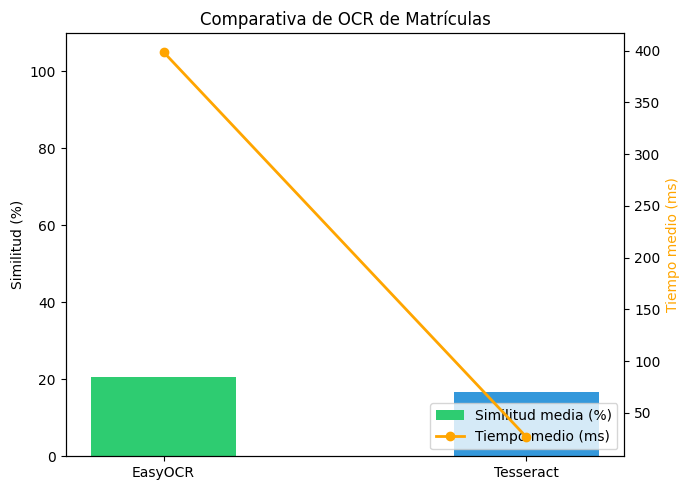

Gráfica guardada como 'comparativa_ocr.png'


: 

In [ ]:
import csv
import os
from Levenshtein import ratio  # pip install python-Levenshtein
import matplotlib.pyplot as plt

def extraer_gt(nombre):
    """Extrae la matrícula esperada del nombre del archivo."""
    base = os.path.splitext(nombre)[0]
    if base.startswith("det_"):
        base = base[len("det_"):]
    return base.upper().replace(" ", "")

def evaluar_csv(csv_path):
    total = 0
    suma_similitud = 0.0
    tiempos = []

    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            total += 1
            gt = extraer_gt(row["imagen"])
            pred = (row["matricula"] or "").upper().replace(" ", "")
            suma_similitud += ratio(gt, pred)

            # Capturar tiempo si existe la columna tiempo_ms
            if "tiempo_inferencia_ms" in row and row["tiempo_inferencia_ms"]:
                try:
                    tiempos.append(float(row["tiempo_inferencia_ms"]))
                except ValueError:
                    pass

    similitud_media = (suma_similitud / total * 100) if total > 0 else 0
    tiempo_medio = (sum(tiempos) / len(tiempos)) if tiempos else 0

    return similitud_media, tiempo_medio


# === Configurá tus CSVs aquí ===
csv_easy = "lecturas_matriculas.csv"
csv_tess = "lecturas_matriculas_tesseract.csv"

# Evaluar ambos
s_easy, t_easy = evaluar_csv(csv_easy)
s_tess, t_tess = evaluar_csv(csv_tess)

# === Gráfica comparativa ===
modelos = ['EasyOCR', 'Tesseract']
similitud = [s_easy, s_tess]
tiempos = [t_easy, t_tess]

fig, ax1 = plt.subplots(figsize=(7, 5))

# Gráfico de barras para similitud
ax1.bar(modelos, similitud, color=['#2ecc71', '#3498db'], width=0.4, label='Similitud media (%)')
ax1.set_ylabel('Similitud (%)', color='black')
ax1.set_ylim(0, 110)
ax1.set_title('Comparativa de OCR de Matrículas')

# Eje secundario para tiempo
ax2 = ax1.twinx()
ax2.plot(modelos, tiempos, color='orange', marker='o', linewidth=2, label='Tiempo medio (ms)')
ax2.set_ylabel('Tiempo medio (ms)', color='orange')

# Combinar leyendas
lns1, labs1 = ax1.get_legend_handles_labels()
lns2, labs2 = ax2.get_legend_handles_labels()
ax1.legend(lns1 + lns2, labs1 + labs2, loc='lower right')

plt.tight_layout()
plt.savefig('comparativa_ocr.png', dpi=300)
plt.show()

print("Gráfica guardada como 'comparativa_ocr.png'")


## Video

### EasyOCR

In [ ]:
import torch
from ultralytics import YOLO
import cv2
import csv
import time

# Configuración mínima
device = 'mps' if torch.cuda.is_available() else 'cpu'
model = YOLO("runs/detect/matriculas_detector24/weights/best.pt")
video_path = "VID_20251016_160058367.mp4"

# Intentar importar EasyOCR, si no está, usar un placeholder
try:
    import easyocr
    easy_reader = easyocr.Reader(['en'])
    OCR_AVAILABLE = True
    print("EasyOCR disponible - procesando matrículas")
except ImportError:
    OCR_AVAILABLE = False
    print("EasyOCR no disponible - solo detección de objetos")

# Abrir video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: No se puede abrir el video")
    exit()

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter("salida_simple.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# CSV simple
csv_file = open("detecciones_simple.csv", 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["frame", "objeto", "confianza", "id", "matricula"])

frame_id = 0
tiempos_ocr = []

def leer_matricula_simple(imagen):
    """Función simplificada para leer matrículas"""
    if not OCR_AVAILABLE or imagen.size == 0:
        return ""
    
    start = time.time()
    try:
        # Redimensionar para mejor OCR
        if imagen.shape[1] < 100:
            escala = 100 / imagen.shape[1]
            nueva_w = int(imagen.shape[1] * escala)
            nueva_h = int(imagen.shape[0] * escala)
            imagen = cv2.resize(imagen, (nueva_w, nueva_h))
        
        # Convertir a grises y mejorar contraste
        gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        gris = cv2.equalizeHist(gris)
        
        # Usar EasyOCR
        resultados = easy_reader.readtext(gris, detail=1, paragraph=False)
        
        if resultados:
            # Tomar el resultado con mayor confianza
            mejor = max(resultados, key=lambda x: x[2])
            texto = ''.join(filter(lambda c: c.isalnum() or c in '- ', mejor[1])).upper()
            
            # Filtrar textos muy cortos o poco probables
            if len(texto) >= 4 and any(c.isdigit() for c in texto):
                tiempos_ocr.append(time.time() - start)
                return texto
            
    except Exception as e:
        print(f"Error en OCR: {e}")

    tiempos_ocr.append(time.time() - start)
    return ""

print("Procesando video...")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_id += 1
    if frame_id % 30 == 0:  # Mostrar progreso cada ~1 segundo
        print(f"Frame {frame_id}...")

    # Detectar solo coches (clase 2)
    # Detección directa de matrículas
    results = model.track(frame, persist=True, device=device, verbose=False)

    if results and results[0].boxes is not None:
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            track_id = int(box.id[0]) if box.id is not None else -1

            matricula = ""
            if OCR_AVAILABLE:
                region_matricula = frame[y1:y2, x1:x2]
                if region_matricula.size > 0:
                    matricula = leer_matricula_simple(region_matricula)

            # Dibujar bounding box y texto
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            texto = f"Plate {track_id if track_id >= 0 else ''}"
            if matricula:
                texto += f" | {matricula}"
                cv2.putText(frame, matricula, (x1 + 10, y2 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

            cv2.putText(frame, texto, (x1 + 10, max(y1 - 10, 20)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        csv_writer.writerow([frame_id, "plate", f"{conf:.2f}", track_id, matricula])

    out.write(frame)
    
    # Mostrar preview
    cv2.imshow("Deteccion Vehiculos", frame)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC para salir
        break

# Limpieza
cap.release()
out.release()
csv_file.close()
cv2.destroyAllWindows()

print(f"\nProcesados {frame_id} frames")
if tiempos_ocr:
    print(f"Tiempo promedio OCR: {sum(tiempos_ocr)/len(tiempos_ocr)*1000:.1f}ms")
    print(f"Total lecturas OCR: {len(tiempos_ocr)}")

EasyOCR disponible - procesando matrículas
Procesando video...
Frame 30...
Frame 60...
Frame 90...
Frame 120...
Frame 150...
Frame 180...
Frame 210...
Frame 240...
Frame 270...
Frame 300...
Frame 330...
Frame 360...
Frame 390...
Frame 420...
Frame 450...
Frame 480...
Frame 510...
Frame 540...
Frame 570...
Frame 600...
Frame 630...
Frame 660...
Frame 690...
Frame 720...
Frame 750...
Frame 780...
Frame 810...
Frame 840...
Frame 870...

Procesados 875 frames
Tiempo promedio OCR: 22.0ms
Total lecturas OCR: 492


### Tesseract

In [6]:
import torch
from ultralytics import YOLO
import cv2
import csv
import time
import pytesseract
import numpy as np

# Configuración del dispositivo
device = 'mps' if torch.cuda.is_available() else 'cpu'

# Modelo entrenado solo para detectar matrículas
model = YOLO("runs/detect/matriculas_detector24/weights/best.pt")

# Ruta del video
video_path = "VID_20251016_160058367.mp4"

# Verificar Tesseract
try:
    _ = pytesseract.get_tesseract_version()
    OCR_AVAILABLE = True
    print("Tesseract disponible - procesando matrículas")
except Exception as e:
    OCR_AVAILABLE = False
    print("Tesseract no disponible:", e)

# Abrir video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: No se puede abrir el video")
    exit()

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter("salida_tesseract.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# CSV
csv_file = open("detecciones_tesseract.csv", 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["frame", "objeto", "confianza", "id", "matricula"])

frame_id = 0
tiempos_tes = []

# === OCR con Tesseract ===
def leer_matricula_tesseract(imagen):
    """Lee texto de una matrícula usando Tesseract."""
    if not OCR_AVAILABLE or imagen.size == 0:
        return ""
    
    start = time.time()
    try:
        # Preprocesamiento
        gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        gris = cv2.bilateralFilter(gris, 9, 75, 75)
        gris = cv2.equalizeHist(gris)
        gris = cv2.adaptiveThreshold(gris, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
        
        # Configuración de Tesseract optimizada para matrículas
        config = "--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        texto = pytesseract.image_to_string(gris, config=config)
        texto = texto.strip().replace(" ", "").upper()
        
        # Filtrar resultados inválidos
        if len(texto) >= 4 and any(c.isdigit() for c in texto):
            tiempos_tes.append(time.time() - start)
            return texto
        
    except Exception as e:
        print(f"Error en OCR: {e}")

    tiempos_tes.append(time.time() - start)
    return ""

print("Procesando video...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_id += 1
    if frame_id % 30 == 0:
        print(f"Frame {frame_id}...")

    # Detección directa de matrículas
    results = model.track(frame, persist=True, device=device, verbose=False)

    if results and results[0].boxes is not None:
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            track_id = int(box.id[0]) if box.id is not None else -1

            matricula = ""
            if OCR_AVAILABLE:
                region_matricula = frame[y1:y2, x1:x2]
                if region_matricula.size > 0:
                    matricula = leer_matricula_tesseract(region_matricula)

            # Dibujar bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Texto
            texto = f"Plate {track_id if track_id >= 0 else ''}"
            if matricula:
                texto += f" | {matricula}"
                cv2.putText(frame, matricula, (x1 + 10, y2 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

            cv2.putText(frame, texto, (x1 + 10, max(y1 - 10, 20)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            # Guardar en CSV
            csv_writer.writerow([frame_id, "plate", f"{conf:.2f}", track_id, matricula])

    out.write(frame)

    cv2.imshow("Deteccion Matrículas", frame)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC
        break

# Limpieza
cap.release()
out.release()
csv_file.close()
cv2.destroyAllWindows()

print(f"\nProcesados {frame_id} frames")
if tiempos_tes:
    print(f"Tiempo promedio OCR: {sum(tiempos_tes)/len(tiempos_tes)*1000:.1f}ms")
    print(f"Total lecturas OCR: {len(tiempos_tes)}")


Tesseract disponible - procesando matrículas
Procesando video...
Frame 30...
Frame 60...
Frame 90...
Frame 120...
Frame 150...
Frame 180...
Frame 210...
Frame 240...
Frame 270...
Frame 300...
Frame 330...
Frame 360...
Frame 390...
Frame 420...
Frame 450...
Frame 480...
Frame 510...
Frame 540...
Frame 570...
Frame 600...
Frame 630...
Frame 660...
Frame 690...
Frame 720...
Frame 750...
Frame 780...
Frame 810...
Frame 840...
Frame 870...

Procesados 875 frames
Tiempo promedio OCR: 74.3ms
Total lecturas OCR: 492
